### Define Helper Functions

In [1]:
from os import listdir
from os.path import isfile, join
import pandas as pd
from datetime import datetime,date,timedelta
import json 
from collections import deque
import pickle
import functools
import time

import multiprocessing  

import re

def matchLineIndex(s):
    ### Convert GLD notation to GeoJson Notation
    integer_list=re.findall(r'\d+', s)    
    return 'line'+integer_list[0]+"to"+integer_list[1]

def disaggMap(dataFrame,nodes_to_loads,parseCase,meters):
    dataFrames=[]
    total=0
    for elem in meters:
        #print(len(dataFrame))
        frame=dataFrame[dataFrame['month']==parseCase['month']].copy(deep=True)
        frame['node']=elem
        counts=nodes_to_loads[nodes_to_loads['name']==elem]
        #print(counts)

        for index,row in frame.iterrows():
            for typ in counts.keys():
                if row['type']==typ:
                    #print(list(frame.columns.difference(['node','hour_of_day','month','type'])))
                    for id in list(frame.columns.difference(['node','hour_of_day','month','type'])):
                        frame.loc[index, id]=float(row[id])*float(counts[typ])
        dataFrames.append(frame)
    finalFrame=pd.concat(dataFrames)
    return(finalFrame)


def getPickles(mypath):
    pickleFiles={}
    for f in set(listdir(mypath)):
        if isfile(join(mypath, f)) and (f[-6:]=="pickle"):
            path=join(mypath, f)
            resourceType=f.replace('.pickle','')
            pickleFiles[resourceType]=path
    return pickleFiles

def parseLoadNodeNames(name):
    if name[0:4]=='load':
        number=name.split('load:')
        nodeType='load_'
    if name[0:4]=='node':
        number=name.split('node:')
        nodeType='node_'
    return nodeType+str(number[1])    
from collections import defaultdict

def children(token, tree):
    "returns a list of every child"
    visited = set()
    to_crawl = deque([token])
    while to_crawl:
        current = to_crawl.popleft()
        if current in visited:
            continue
        visited.add(current)
        node_children = set(tree[current])
        to_crawl.extend(node_children - visited)
    return list(visited)

def addDashtoNodeName(nodename):
    nodename=nodename.split('node')
    return('node_'+nodename[1])

def addDashtoLoadName(loadname):
    loadname=loadname.split('load')
    return('load_'+loadname[1])

def columnFormat(columnName):
    columnName=columnName.lower()
    if columnName[0:4]=='node':
        columnName=addDashtoNodeName(columnName)
    if columnName[0:4]=='load':
        columnName=addDashtoLoadName(columnName)
    return columnName

def monthMapper(month):
    date = datetime(2000, month, 1)  # We need a dateobject with the proper month
    return date.strftime('%B').lower()

def parseVoltages(voltage_files):
    voltage_dfs={}
    voltage_dfs_flattened={}
    for voltage_name,filename in voltage_files.items():
        voltage_dfs[voltage_name]=pd.read_csv(filename,skiprows=list(range(0,8)),parse_dates=['# timestamp'])

    for voltage_name,df in voltage_dfs.items():
        df.columns = [columnFormat(col_name) for col_name in df.columns]
        df['# timestamp'] = df['# timestamp'].map(lambda x: x.tz_localize('UTC').tz_convert('US/Pacific'))
        df['month'] = df['# timestamp'].map(lambda x: monthMapper(x.month))
        df['hour_of_day'] = df['# timestamp'].map(lambda x: x.hour)
        df['day_of_month'] = df['# timestamp'].map(lambda x: x.day)
        df['timezone']= df['# timestamp'].map(lambda x: x.tz)
        ### Get all the node names
        nodeNames=[]
        for columnName in df.columns:
            if columnName[0:4]=='node':
                nodeNames.append(columnName)
            if columnName[0:4]=='load':
                nodeNames.append(columnName)

        df=pd.melt(df, id_vars=['month','hour_of_day','day_of_month'],var_name='node',value_vars=nodeNames, value_name=voltage_name+'_magnitude')
        df[voltage_name+'_magnitude']=df[voltage_name+'_magnitude'].map(lambda x:abs(complex(x.replace('i','j'))))


        voltage_dfs_flattened[voltage_name]=df
    voltageData = functools.reduce(lambda left,right: pd.merge(left,right,on=['month', 'day_of_month', 'hour_of_day','node']), voltage_dfs_flattened.values())
    
#     for vname,vframe in voltage_dfs_flattened.items():
#         voltageData=voltageData.merge(vframe,on=['month', 'day_of_month', 'hour_of_day','node'],how='left')

    return(voltageData)

def tryconvertreal(value):
        try:
            S=complex(value.replace('i','j'))
            return S.real
        except:
            return value

        
def tryconvertimag(value):
        try:
            S=complex(value.replace('i','j'))
            return S.imag
        except:
            return value
        
def tryconvertmag(value):
        try:
            return abs(complex(value.replace('i','j')))
        except:
            return value
        
def parsePowerFlow(power_files):
    power_dfs={}
    power_dfs_flattened={}
    for power_name,filename in power_files.items():
        power_dfs[power_name]=pd.read_csv(filename,skiprows=list(range(0,8)),parse_dates=['# timestamp'])

    for power_name,df in power_dfs.items():
        df['# timestamp'] = df['# timestamp'].map(lambda x: x.tz_localize('UTC').tz_convert('US/Pacific'))
        df['month'] = df['# timestamp'].map(lambda x: monthMapper(x.month))
        df['hour_of_day'] = df['# timestamp'].map(lambda x: x.hour)
        df['day_of_month'] = df['# timestamp'].map(lambda x: x.day)
        df['timezone']= df['# timestamp'].map(lambda x: x.tz)
        
        lineNames=[]
        replaceCols=[]
        for lineName in df.columns:
            if lineName[0]=='O':
                geoJsonLineName=matchLineIndex(lineName)
                lineNames.append(geoJsonLineName)
                replaceCols.append(geoJsonLineName)
            else:
                replaceCols.append(lineName)

        df.columns=replaceCols
        df=pd.melt(df, id_vars=['month','hour_of_day','day_of_month'],var_name='line',value_vars=lineNames, value_name=power_name+'_magnitude')
        df[power_name+'_P']=df[power_name+'_magnitude'].map(lambda x:tryconvertreal(x))
        df[power_name+'_Q']=df[power_name+'_magnitude'].map(lambda x:tryconvertimag(x))
        df[power_name+'_magnitude']=df[power_name+'_magnitude'].map(lambda x:tryconvertmag(x))


        power_dfs_flattened[power_name]=df
    powerData = functools.reduce(lambda left,right: pd.merge(left,right,on=['month', 'day_of_month', 'hour_of_day','line']), power_dfs_flattened.values())

    return(df,powerData)


def parseTransmission(transmission_files):
    # # # Line data 
    # # # Dates,Pfrom(kW),Qfrom(KVar),Pto(kW)
    # # # Node data 
    # # # Dates,Vm(kV),Va(deg),Pl(kW),Ql(KVar)

    transmission_dfs={}
    transmission_dfs_flattened={}
    for transmission_name,filename in transmission_files.items():
        transmission_dfs[transmission_name]=pd.read_csv(filename,skiprows=list(range(0,2)),parse_dates=['Dates'])

    for transmission_name, df in transmission_dfs.items():
        df['Dates'] = df['Dates'].map(lambda x: x.tz_localize('UTC').tz_convert('US/Pacific'))
        df['month'] = df['Dates'].map(lambda x: monthMapper(x.month))
        df['hour_of_day'] = df['Dates'].map(lambda x: x.hour)
        df['day_of_month'] = df['Dates'].map(lambda x: x.day)
        df['timezone']= df['Dates'].map(lambda x: x.tz)

        transmission_dfs_flattened[transmission_name]=df
    transmissionData = functools.reduce(lambda left,right: pd.merge(left,right,on=['month', 'day_of_month', 'hour_of_day']), transmission_dfs_flattened.values())

    return(df,transmissionData)




### Parse Node Level Results from DERCAM, GridlabD and Topology Files for Distribution System View

In [33]:
dataKeys=['hourly_pv_self_consumpt',
          'hourly_pv_export',
          'elec_stored_stationnary_batteries',
          'purchase_from_utility',
          'elec_provided_by_stationnary_battery_charging_after_eff','pv_inst','storage_inst','chp_inst']
##pv_inst
##storage_inst
##chp_inst
for scenario_number in [1,2,3,4]:
    scenario_names=['BC','PV','PV+STO','PV+STO+CHP']
    scenario_name=scenario_names[scenario_number-1]
    save_final_data_file='../GMLCDjangoProject/MapApp/static/MapApp/data/scenario'+str(scenario_number-1)+'.csv'

    parseList=[]
    for i in range(1,13):
        mydate = date(2016,i,1)

        fileLocation="/Month"+"%02d" % i +"/output/"
        gridlabd_scenario_path='./GRIDLABD_Results/'+scenario_name+fileLocation
        gld=pd.read_csv(gridlabd_scenario_path+'/nodes_voltage_A.csv',skiprows=list(range(0,8)),parse_dates=['# timestamp'])
        datetimes=gld['# timestamp'].map(lambda x: x.tz_localize('UTC').tz_convert('US/Pacific').date())
        dayWeekday={}
        weekend=False
        weekday=False
        for elem in sorted(set(datetimes)):
            if elem.weekday()<5:
                weekday=elem.day
            else: 
                weekend=elem.day

            if weekend & weekday:
                break
        parseList.append({'month':mydate.strftime("%B").lower(),'filename':"/Month"+"%02d" % i +"/output/",'weekday':weekday})
        parseList.append({'month':mydate.strftime("%B").lower(),'filename':"/Month"+"%02d" % i +"/output/",'weekend':weekend})



    merge_list=[]


    for parseCase in parseList:

        dercam_scenario_path="./DERCAM_Results/"+scenario_name+"/gmlc/buildings"
        gridlabd_scenario_path='./GRIDLABD_Results/'+scenario_name+parseCase['filename']
                         
                         
        filenames=getPickles(dercam_scenario_path)




        voltage_files={'voltage_a':gridlabd_scenario_path+'/nodes_voltage_A.csv',
                       'voltage_b':gridlabd_scenario_path+'/nodes_voltage_B.csv',
                       'voltage_c':gridlabd_scenario_path+'/nodes_voltage_C.csv',}

        load_voltages={'voltage_a':gridlabd_scenario_path+'/loads_voltage_A.csv',
                       'voltage_b':gridlabd_scenario_path+'/loads_voltage_B.csv',
                       'voltage_c':gridlabd_scenario_path+'/loads_voltage_C.csv'}


        #### PARSE GRIDLABD
        print("*********Parsing GridlabD")

        st_time=time.time()
        print(voltage_files)
        print(load_voltages)
        voltageData=parseVoltages(voltage_files)
        loadVoltageData=parseVoltages(load_voltages)
        if 'weekend' in parseCase.keys():
            print('Parsing Weekend')
            day_of_month=parseCase['weekend']
            weekend=True
        else:
            day_of_month=parseCase['weekday']
            weekend=False

        daily_node_voltage=voltageData[voltageData['month']==parseCase['month']][voltageData['day_of_month']==day_of_month][["month","hour_of_day","node",
                                                                                                         "voltage_b_magnitude","voltage_c_magnitude" ,"voltage_a_magnitude"]]
        daily_load_voltage=loadVoltageData[loadVoltageData['month']==parseCase['month']][loadVoltageData['day_of_month']==day_of_month][["month","hour_of_day","node",
                                                                                                          "voltage_b_magnitude","voltage_c_magnitude" ,"voltage_a_magnitude"]]
        st_time2=time.time()
        print("Took ",st_time2-st_time)
        st_time=st_time2

        print("*********Parsing DERCAM")

        ### PARSE DERCAM FILES
        ## Flatten files to facilitate the use of crossfilter and dc.js
        if weekend:
            keys=['weekend']
        else:
            keys=['week']
        dataFrames=[]
        for resourceType,filename in filenames.items():
            #print("reading "+filename)
            try:
                with open(filename, 'rb') as input_file:
                    data = pickle.load(input_file)
                ct=0
                print('These exist')
                print([val for val in set(list(data.keys())) if val in set(dataKeys)])
                print('These are missing')
                print(set(list(data.keys())).symmetric_difference(set(dataKeys)))
                for elem in dataKeys:
                    try:
                        for key in keys:#data[elem].keys():
                            #print(filename,elem,key)
                            #print(data[elem].keys())
                            dummy=data[elem][key]
                            #ataFrame['type']=key
                            #ataFrame['variable']=elem
                            dummy=pd.melt(dummy, id_vars=['month'],var_name='hour_of_day',value_name=elem)
                            dummy[elem] = dummy[elem].astype(float)
                            if ct==0:
                                dataFrame=dummy
                            if ct>0:
                                dataFrame=pd.merge(dataFrame,dummy,on=['month','hour_of_day'])
                            ct=ct+1
                    except:
                        print('failed for '+filename,elem)
                        continue
                dataFrame['type']=resourceType
                if 'pv_inst' in set(list(data.keys())):
                    dataFrame['pv_inst']=float(data['pv_inst'])
                if 'storage_inst' in set(list(data.keys())):
                    dataFrame['storage_inst']=float(data['storage_inst'])
                if 'chp_inst' in set(list(data.keys())):
                    dataFrame['chp_inst']=float(data['chp_inst'])
                dataFrames.append(dataFrame)
            except:
                print("Couldn't process "+filename)

        dataFrame=pd.concat(dataFrames)
        dataFrame=dataFrame.fillna(value=0)
        dataFrame=dataFrame.reset_index(drop=True)
        st_time2=time.time()
        print("Took ",st_time2-st_time)
        st_time=st_time2



        ### PARSE TOPOLOGY
        print("*********Parsing Topology")
        with open('ieee123.json') as data_file:    
            data = json.load(data_file)
        fromToDict=defaultdict(list)
        for elem in data:
            if 'overhead_line:' in elem['selector']:
                fromToDict[parseLoadNodeNames(elem["properties"]['from'])].append(parseLoadNodeNames(elem["properties"]['to']))


        nodeChildrenDict=defaultdict(list)
        for node in set(daily_node_voltage['node']):
            for elem in children(node,fromToDict):
                if elem[0:4]=='load':
                    nodeChildrenDict[node].append(elem)

        nodes_to_loads=pd.read_csv(dercam_scenario_path+"/disaggregation.csv")
        nodes_to_loads['name']=nodes_to_loads['name'].apply(lambda x:x.replace('Load','load_') )


        for node,node_list in nodeChildrenDict.items():
            dummy=nodes_to_loads[
                nodes_to_loads['name'].isin(
                    node_list)].sum(axis=0)
            dummy['name']=node
            nodes_to_loads=nodes_to_loads.append(dummy, ignore_index=True)
        ## Sum up everything and create node and load consumption patterns
        meters=list(nodes_to_loads['name'])
        st_time2=time.time()
        print("Took ",st_time2-st_time)
        st_time=st_time2


        ### PARSE DISAGG

        print("*********Parsing Disagg")


        #dataFrame.to_csv('Dercam_initial.csv')
        #nodes_to_loads.to_csv('nodes_to_loads.csv')


        finalFrame=disaggMap(dataFrame,nodes_to_loads,parseCase,meters)

        st_time2=time.time()
        print("Took ",st_time2-st_time)
        st_time=st_time2
        ## Down select DERCAM data to match the first month

        dercamData=finalFrame[finalFrame['month']==parseCase['month']]
        dercamData['hour_of_day']=dercamData['hour_of_day'].apply(lambda x:x-1)
        ## Stich everything GLD and DERCAM all together
        voltageFrame=daily_load_voltage.append(daily_node_voltage)
        merge_test=dercamData.merge(voltageFrame,on=['month', 'hour_of_day','node'],how='left')
        if weekend:
            merge_test['daytype']='weekend'
        else:
            merge_test['daytype']='weekday'
        #merge_test=merge_test.merge(daily_node_voltage,on=['month', 'hour_of_day','node'],how='left')
        merge_list.append(merge_test)




    print('Saving file to '+save_final_data_file)
    merge_test_df=pd.concat(merge_list)
    merge_test_df.reset_index(drop=True).to_csv(save_final_data_file)








*********Parsing GridlabD
{'voltage_a': './GRIDLABD_Results/BC/Month01/output//nodes_voltage_A.csv', 'voltage_b': './GRIDLABD_Results/BC/Month01/output//nodes_voltage_B.csv', 'voltage_c': './GRIDLABD_Results/BC/Month01/output//nodes_voltage_C.csv'}
{'voltage_a': './GRIDLABD_Results/BC/Month01/output//loads_voltage_A.csv', 'voltage_b': './GRIDLABD_Results/BC/Month01/output//loads_voltage_B.csv', 'voltage_c': './GRIDLABD_Results/BC/Month01/output//loads_voltage_C.csv'}
Took  0.3242299556732178
*********Parsing DERCAM
These exist
['purchase_from_utility', 'elec_provided_by_stationnary_battery_charging_after_eff', 'pv_inst', 'storage_inst', 'elec_stored_stationnary_batteries', 'hourly_pv_self_consumpt', 'hourly_pv_export']
These are missing
{'renewables_new_capacity', 'chp_inst', 'doc', 'net_load', 'OPEX_saving', 'elec_for_stationnary_battery_charging_before_eff', 'ren_gen', 'energy_storage_new_capacity'}
failed for ./DERCAM_Results/BC/gmlc/buildings/ResidLow.pickle.pickle hourly_pv_self_c

In [57]:
filename="./DERCAM_Results/PV+STO/gmlc/buildings/SmallOffice.pickle.pickle"
with open(filename, 'rb') as input_file:
                    data = pickle.load(input_file)

In [58]:
data

{'OPEX_saving': 49.0,
 'doc': [{'id': 'Saving (%)', 'name': 'OPEX_saving', 'type': 'value'},
  {'id': '1.1.2.1 Renewables (PV and Solar Thermal)',
   'name': 'renewables_new_capacity',
   'type': 'table'},
  {'id': '++++++ 1.2 Energy Storage',
   'name': 'energy_storage_new_capacity',
   'type': 'table'},
  {'id': '*** Hourly PV output for self consumption',
   'name': 'hourly_pv_self_consumpt',
   'type': 'timeserie'},
  {'id': '*** Hourly PV output for export ',
   'name': 'hourly_pv_export',
   'type': 'timeserie'},
  {'id': '*** Electricity stored in Stationary Batteries (kWh)',
   'name': 'elec_stored_stationnary_batteries',
   'type': 'timeserie'},
  {'id': 'Electricity for Stationary Battery charging (before charging efficiency) (kW)',
   'name': 'elec_for_stationnary_battery_charging_before_eff',
   'type': 'timeserie'},
  {'id': '*** Electricity Provided by the Stationary Battery (after discharging efficiency) (kW)',
   'name': 'elec_provided_by_stationnary_battery_charging_af

In [11]:
for elem in data['doc']:
    print(elem['id'])
data['pv_inst']

Saving (%)
1.1.2.1 Renewables (PV and Solar Thermal)
++++++ 1.2 Energy Storage
*** Hourly PV output for self consumption
*** Hourly PV output for export 
*** Electricity stored in Stationary Batteries (kWh)
Electricity for Stationary Battery charging (before charging efficiency) (kW)
*** Electricity Provided by the Stationary Battery (after discharging efficiency) (kW)
*** Hourly purchase from electric utility (kW)
Net load at the meter in KW (Power Import - Export)
Total renewable generation (kWh)
"PV"
"Storage"


1.06

### Match Line Notation Between GeoJson and Line Power Data

In [11]:
gridlabd_scenario_path='./GRIDLABD_Results/'+scenario_name+parseCase['filename']

### Get headers of each data file overhead, underground 
file_names=["underground_lines_power_in_A", 
            "Overhead_lines_power_in_A",
            "underground_lines_power_in_B", 
            "Overhead_lines_power_in_B",
            "underground_lines_power_in_C", 
            "Overhead_lines_power_in_C",
           ]

line_df={}
lines=[]
for filename in file_names:
    line_df[filename]=pd.read_csv(gridlabd_scenario_path+filename+".csv",skiprows=list(range(0,8)),parse_dates=['# timestamp'])
    lines=lines+list(line_df[filename].keys())

### Final list of lines 
lines=list(set(lines))
lines.remove('# timestamp')

### Get lines from the geojson
geoJsonData = json.load(open('../GMLCDjangoProject/MapApp/static/MapApp/data/model2.geo.json'))

lines_in_geojson=[]
for feature in geoJsonData['features']:
    if feature["geometry"]["type"]=="LineString":
        lines_in_geojson.append(feature['properties']['name'])

lines_in_geojson=list(set(lines_in_geojson))

matched_lines=[]
for elem in lines:
    matched_lines.append(matchLineIndex(elem))    
mismatch_list=[]
for elem in matched_lines:
    if elem not in lines_in_geojson:
        mismatch_list.append(elem)


### Parse Line Data

In [44]:
dataKeys=['hourly_pv_self_consumpt',
          'hourly_pv_export',
          'elec_stored_stationnary_batteries',
          'purchase_from_utility',
          'elec_provided_by_stationnary_battery_charging_after_eff']
##pv_inst
##storage_inst
##chp_inst
for scenario_number in [1,2,3,4]:
    scenario_names=['BC','PV','PV+STO','PV+STO+CHP']
    scenario_name=scenario_names[scenario_number-1]
    save_final_data_file='../GMLCDjangoProject/MapApp/static/MapApp/data/scenario'+str(scenario_number-1)+'_lines.csv'

    parseList=[]
    for i in range(1,13):
        mydate = date(2016,i,1)

        fileLocation="/Month"+"%02d" % i +"/output/"
        gridlabd_scenario_path='./GRIDLABD_Results/'+scenario_name+fileLocation
        gld=pd.read_csv(gridlabd_scenario_path+'/nodes_voltage_A.csv',skiprows=list(range(0,8)),parse_dates=['# timestamp'])
        datetimes=gld['# timestamp'].map(lambda x: x.tz_localize('UTC').tz_convert('US/Pacific').date())
        dayWeekday={}
        weekend=False
        weekday=False
        for elem in sorted(set(datetimes)):
            if elem.weekday()<5:
                weekday=elem.day
            else: 
                weekend=elem.day

            if weekend & weekday:
                break
        parseList.append({'month':mydate.strftime("%B").lower(),'filename':"/Month"+"%02d" % i +"/output/",'weekday':weekday})
        parseList.append({'month':mydate.strftime("%B").lower(),'filename':"/Month"+"%02d" % i +"/output/",'weekend':weekend})



    merge_list=[]
    for parseCase in parseList:

        gridlabd_scenario_path='./GRIDLABD_Results/'+scenario_name+parseCase['filename']

        overhead_power_flow_files={'power_in_a':gridlabd_scenario_path+'Overhead_lines_power_in_A.csv',
                                   'power_in_b':gridlabd_scenario_path+'Overhead_lines_power_in_B.csv',
                                   'power_in_c':gridlabd_scenario_path+'Overhead_lines_power_in_C.csv'
                            }
        overhead_power_flow_out_files={'power_out_a':gridlabd_scenario_path+'Overhead_lines_power_out_A.csv',
                                   'power_out_b':gridlabd_scenario_path+'Overhead_lines_power_out_B.csv',
                                   'power_out_c':gridlabd_scenario_path+'Overhead_lines_power_out_C.csv'
                            }

    #     underground_power_flow_files={'power_in_a':gridlabd_scenario_path+'underground_lines_power_in_A.csv',
    #                                   'power_in_b':gridlabd_scenario_path+'underground_lines_power_in_B.csv',
    #                                   'power_in_c':gridlabd_scenario_path+'underground_lines_power_in_C.csv'
    #                     }

    #     underground_power_flow_out_files={'power_out_a':gridlabd_scenario_path+'underground_lines_power_in_A.csv',
    #                               'power_out_b':gridlabd_scenario_path+'underground_lines_power_in_B.csv',
    #                               'power_out_c':gridlabd_scenario_path+'underground_lines_power_in_C.csv'
    #                 }
        #### PARSE GRIDLABD
        print("*********Parsing GridlabD")

        st_time=time.time()
        df,powerOverHeadData=parsePowerFlow(overhead_power_flow_files)
    #     df,powerUnderGroundData=parsePowerFlow(underground_power_flow_files)

        df,powerOverHeadOutData=parsePowerFlow(overhead_power_flow_out_files)
    #     df,powerUnderGroundOutData=parsePowerFlow(underground_power_flow_out_files)

        if 'weekend' in parseCase.keys():
            print('Parsing Weekend')
            day_of_month=parseCase['weekend']
            weekend=True
        else:
            day_of_month=parseCase['weekday']
            weekend=False

        daily_overhead_line_power=powerOverHeadData[powerOverHeadData['month']==parseCase['month']][powerOverHeadData['day_of_month']==day_of_month][["month","hour_of_day","line",
                                                                                                         "power_in_b_magnitude","power_in_c_magnitude" ,"power_in_a_magnitude",
                                                                                                         "power_in_b_Q","power_in_c_Q" ,"power_in_a_Q",
                                                                                                           "power_in_b_P","power_in_c_P" ,"power_in_a_P"]]

    #     daily_underground_line_power=powerUnderGroundData[powerUnderGroundData['month']==parseCase['month']][powerUnderGroundData['day_of_month']==day_of_month][["month","hour_of_day","line",
    #                                                                                                      "power_in_b_magnitude","power_in_c_magnitude" ,"power_in_a_magnitude"]]

        daily_overhead_line_out_power=powerOverHeadOutData[powerOverHeadOutData['month']==parseCase['month']][powerOverHeadOutData['day_of_month']==day_of_month][["month","hour_of_day","line",
                                                                                                         "power_out_b_magnitude","power_out_c_magnitude" ,"power_out_a_magnitude",
                                                                                                         "power_out_b_Q","power_out_c_Q" ,"power_out_a_Q",
                                                                                                           "power_out_b_P","power_out_c_P" ,"power_out_a_P"]]

        st_time2=time.time()
        print("Took ",st_time2-st_time)
        st_time=st_time2

    #    powerFrame=daily_overhead_line_power.append(daily_underground_line_power)
    #    powerOutFrame=daily_overhead_line_out_power.append(daily_underground_line_out_power)


        powerFrame=daily_overhead_line_power
        powerOutFrame=daily_overhead_line_out_power
        merge_test=powerFrame.merge(powerOutFrame,on=['month', 'hour_of_day','line'],how='left')


        if weekend:
            merge_test['daytype']='weekend'
        else:
            merge_test['daytype']='weekday'

        merge_test['power_flow_a']=merge_test['power_in_a_magnitude']-merge_test['power_out_a_magnitude']
        merge_test['power_flow_b']=merge_test['power_in_b_magnitude']-merge_test['power_out_b_magnitude']
        merge_test['power_flow_c']=merge_test['power_in_c_magnitude']-merge_test['power_out_c_magnitude']
        
        merge_test['power_flow_a_Q']=merge_test['power_in_a_Q']-merge_test['power_out_a_Q']
        merge_test['power_flow_b_Q']=merge_test['power_in_b_Q']-merge_test['power_out_b_Q']
        merge_test['power_flow_c_Q']=merge_test['power_in_c_Q']-merge_test['power_out_c_Q']


        merge_test['power_flow_a_P']=merge_test['power_in_a_P']-merge_test['power_out_a_P']
        merge_test['power_flow_b_P']=merge_test['power_in_b_P']-merge_test['power_out_b_P']
        merge_test['power_flow_c_P']=merge_test['power_in_c_P']-merge_test['power_out_c_P']





        #merge_test=merge_test.merge(daily_node_voltage,on=['month', 'hour_of_day','node'],how='left')
        merge_list.append(merge_test)




    print('Saving file to '+save_final_data_file)
    merge_test_df=pd.concat(merge_list)
    merge_test_df.reset_index(drop=True).to_csv(save_final_data_file)






*********Parsing GridlabD
Took  0.6903760433197021
*********Parsing GridlabD
Parsing Weekend
Took  0.6529929637908936
*********Parsing GridlabD
Took  0.4850454330444336
*********Parsing GridlabD
Parsing Weekend
Took  0.49858617782592773
*********Parsing GridlabD
Took  0.36746788024902344
*********Parsing GridlabD
Parsing Weekend
Took  0.3653531074523926
*********Parsing GridlabD
Took  0.3401951789855957
*********Parsing GridlabD
Parsing Weekend
Took  0.3437838554382324
*********Parsing GridlabD
Took  0.42154979705810547
*********Parsing GridlabD
Parsing Weekend
Took  0.37958502769470215
*********Parsing GridlabD
Took  0.370725154876709
*********Parsing GridlabD
Parsing Weekend
Took  0.3967108726501465
*********Parsing GridlabD
Took  0.4030008316040039
*********Parsing GridlabD
Parsing Weekend
Took  0.4917910099029541
*********Parsing GridlabD
Took  0.40772390365600586
*********Parsing GridlabD
Parsing Weekend
Took  0.5036399364471436
*********Parsing GridlabD
Took  0.45844411849975586


In [46]:
test_df=merge_test_df[(merge_test_df['node']=='load_41')&(merge_test_df['month']=='december') & (merge_test_df['daytype']=='weekend')]

In [56]:
data

[{'nested': [],
  'path': 'clock',
  'properties': {'starttime': "'2016-07-07 00:00:00'",
   'stoptime': "'2016-07-08 00:00:00'",
   'timezone': 'PST+8PDT'},
  'selector': ['clock']},
 {'nested': [],
  'path': 'module tape',
  'properties': {},
  'selector': ['module', 'tape']},
 {'nested': [],
  'path': 'module powerflow',
  'properties': {},
  'selector': ['module', 'powerflow']},
 {'nested': [],
  'path': 'object overhead_line_conductor:10001',
  'properties': {'geometric_mean_radius': '0.0244', 'resistance': '0.30600'},
  'selector': ['object', 'overhead_line_conductor:10001']},
 {'nested': [],
  'path': 'object overhead_line_conductor:10009',
  'properties': {'geometric_mean_radius': '0.004460', 'resistance': '1.12000'},
  'selector': ['object', 'overhead_line_conductor:10009']},
 {'nested': [],
  'path': 'object overhead_line_conductor:10002',
  'properties': {'geometric_mean_radius': '0.008140', 'resistance': '0.59200'},
  'selector': ['object', 'overhead_line_conductor:10002']}

In [50]:
test_df

,elec_provided_by_stationnary_battery_charging_after_eff,elec_stored_stationnary_batteries,hour_of_day,hourly_pv_self_consumpt,month,purchase_from_utility,pv_inst,storage_inst,type,node,voltage_b_magnitude,voltage_c_magnitude,voltage_a_magnitude,daytype
3888,0.0,0.0,0,0.0,december,0.0,0.0,0.0,ResidLow,load_41,0.0,2485.038481,0.0,weekend
3889,0.0,0.0,1,0.0,december,0.0,0.0,0.0,ResidLow,load_41,0.0,2486.622888,0.0,weekend
3890,0.0,0.0,2,0.0,december,0.0,0.0,0.0,ResidLow,load_41,0.0,2487.300979,0.0,weekend
3891,0.0,0.0,3,0.0,december,0.0,0.0,0.0,ResidLow,load_41,0.0,2487.282758,0.0,weekend
3892,0.0,0.0,4,0.0,december,0.0,0.0,0.0,ResidLow,load_41,0.0,2486.165272,0.0,weekend
3893,0.0,0.0,5,0.0,december,0.0,0.0,0.0,ResidLow,load_41,0.0,2482.803345,0.0,weekend
3894,0.0,0.0,6,0.0,december,0.0,0.0,0.0,ResidLow,load_41,0.0,2477.159443,0.0,weekend
3895,0.0,0.0,7,0.0,december,0.0,0.0,0.0,ResidLow,load_41,0.0,2475.044612,0.0,weekend
3896,0.0,0.0,8,0.0,december,0.0,0.0,0.0,ResidLow,load_41,0.0,2485.367752,0.0,weekend
3897,0.0,0.0,9,0.0,december,0.0,0.0,0.0,ResidLow,load_41,0.0,2491.408878,0.0,weekend


/Users/emrecan/Work_Git/GMLC/venv/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


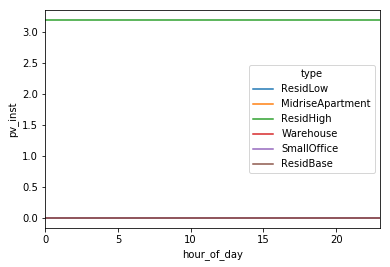

In [59]:
import seaborn as sns
%matplotlib inline
sns.tsplot(data=test_df, time="hour_of_day", unit="daytype",condition="type", value="pv_inst")

### Parse Transmission Data


In [125]:
from os import listdir
import csv

def get_daytype(datetime):
    if datetime.weekday()<5:
        return "weekday"
    else: 
        return "weekend"





def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

### Get second line for object name

transmission_folder_path="/Users/emrecan/Work_Git/GMLC/DataAnalysis/Transmission/"
csvList=find_csv_filenames( transmission_folder_path)
transmissionbus_dfs=[]
transmissionline_dfs=[]


for filename in csvList:
    if "bus" in filename:
        name=filename.split('data.csv')
        df=pd.read_csv(transmission_folder_path+filename,skiprows=list(range(0,2)),parse_dates=['Dates'])
        df['node']=name[0]
        df['Dates'] = df['Dates'].map(lambda x: x.tz_localize('UTC').tz_convert('US/Pacific'))
        
        df['voltage_magnitude']=df['Vm(kV)']
        df['voltage_angle']=df['Va(deg)']
        df['active_power']=df['Pl(kW)']
        df['reactive_power']=df['Ql(KVar)']
        
        df['month'] = df['Dates'].map(lambda x: monthMapper(x.month))
        df['hour_of_day'] = df['Dates'].map(lambda x: x.hour)
        df['day_of_month'] = df['Dates'].map(lambda x: x.day)
        df['daytype'] = df['Dates'].map(lambda x: get_daytype(x))
        df['timezone']= df['Dates'].map(lambda x: x.tz)
        df.drop(['Dates','Vm(kV)','Va(deg)','Pl(kW)','Ql(KVar)'], axis=1,inplace=True)
        transmissionbus_dfs.append(df)
    elif "line" in filename:
        print(filename)
        name=filename.split('data.csv')
        df=pd.read_csv(transmission_folder_path+filename,skiprows=list(range(0,3)),parse_dates=['Dates'])
        df['Dates'] = df['Dates'].map(lambda x: x.tz_localize('UTC').tz_convert('US/Pacific'))
        
        df['active_power_from']=df['Pfrom(kW)']
        df['active_power_to']=df['Pto(kW)']
        df['reactive_power_from']=df['Qfrom(KVar)']
        df['reactive_power_to']=df['Qto(kVar)']

        
        df['month'] = df['Dates'].map(lambda x: monthMapper(x.month))
        df['hour_of_day'] = df['Dates'].map(lambda x: x.hour)
        df['day_of_month'] = df['Dates'].map(lambda x: x.day)
        df['daytype'] = df['Dates'].map(lambda x: get_daytype(x))
        df['timezone']= df['Dates'].map(lambda x: x.tz)
        df.drop(['Dates','Pfrom(kW)','Pto(kW)','Qfrom(KVar)','Qto(kVar)'], axis=1,inplace=True)
        df['line']=name[0]
        transmissionline_dfs.append(df)

transmission_lines=pd.concat(transmissionline_dfs)
transmission_nodes=transmissionbus_dfs[0]

transmission_lines.to_csv('../GMLCDjangoProject/MapApp/static/MapApp/data/transmission/scenario0_lines.csv')
transmission_nodes.to_csv('../GMLCDjangoProject/MapApp/static/MapApp/data/transmission/scenario0.csv')

WECCline174data.csv
WECCline176data.csv
WECCline177data.csv
WECCline256data.csv
WECCline257data.csv
WECCline258data.csv


In [127]:
transmission_nodes


,node,voltage_magnitude,voltage_angle,active_power,reactive_power,month,hour_of_day,day_of_month,daytype,timezone
0,WECCbus154,343.1715,-60.52,956.6,157.7,february,16,28,weekday,US/Pacific
1,WECCbus154,343.3440,-59.61,925.5,158.9,february,17,28,weekday,US/Pacific
2,WECCbus154,343.4130,-59.17,910.7,159.5,february,18,28,weekday,US/Pacific
3,WECCbus154,343.3785,-59.34,916.3,159.2,february,19,28,weekday,US/Pacific
4,WECCbus154,343.3095,-59.71,929.0,158.8,february,20,28,weekday,US/Pacific
5,WECCbus154,342.9300,-61.81,999.8,156.1,february,21,28,weekday,US/Pacific
6,WECCbus154,342.2400,-65.45,1119.0,151.6,february,22,28,weekday,US/Pacific
7,WECCbus154,341.9985,-66.59,1155.0,150.2,february,23,28,weekday,US/Pacific
8,WECCbus154,342.2745,-65.28,1113.0,151.8,march,0,1,weekday,US/Pacific
9,WECCbus154,342.3780,-64.75,1096.0,152.4,march,1,1,weekday,US/Pacific


### Shift regions for SCE and SDGE

In [181]:
import json
from pprint import pprint

endpoint_list=['node','load','substations','model.geo']
### MOVING FROM  35.416667,-119.05
### TO Santa Ana 33.7394197,-117.9055612
### TO San Diego 32.7012145,-117.110277

delta_longitude=-117.9055612+119.05
delta_latitude=33.7394197-35.416667
region="sce"

for elem_name in endpoint_list:
    print("Parsing "+elem_name)
    data = json.load(open('../GMLCDjangoProject/MapApp/static/MapApp/data/pge/endpoints/'+elem_name+'.json'))
    if elem_name=='model.geo':
        for elem in data['features']:
            if elem['geometry']['type']=="Point":
                elem['geometry']['coordinates'][0]=elem['geometry']['coordinates'][0]+delta_longitude
                elem['geometry']['coordinates'][1]=elem['geometry']['coordinates'][1]+delta_latitude
            elif elem['geometry']['type']=="LineString":
                for elemcoor in elem['geometry']['coordinates']:
                    elemcoor[0]=elemcoor[0]+delta_longitude
                    elemcoor[1]=elemcoor[1]+delta_latitude
        
        with open('../GMLCDjangoProject/MapApp/static/MapApp/data/'+region+'/endpoints/'+elem_name+'.json', 'w') as fp:
            json.dump(data,fp)
    
    else:
        for elem in data:
            if 'latitude' in elem.keys():
                elem['longitude']=float(elem['longitude'])+delta_longitude
                elem['latitude']=float(elem['latitude'])+delta_latitude
        with open('../GMLCDjangoProject/MapApp/static/MapApp/data/'+region+'/endpoints/'+elem_name+'.json', 'w') as fp:
            json.dump(data,fp)

### TO San Diego 32.7012145,-117.110277
            
delta_longitude=-117.110277+119.05
delta_latitude=32.7012145-35.416667
region="sdge"

for elem_name in endpoint_list:
    print("Parsing "+elem_name)
    data = json.load(open('../GMLCDjangoProject/MapApp/static/MapApp/data/pge/endpoints/'+elem_name+'.json'))
    if elem_name=='model.geo':
        for elem in data['features']:
            if elem['geometry']['type']=="Point":
                elem['geometry']['coordinates'][0]=elem['geometry']['coordinates'][0]+delta_longitude
                elem['geometry']['coordinates'][1]=elem['geometry']['coordinates'][1]+delta_latitude
            elif elem['geometry']['type']=="LineString":
                for elemcoor in elem['geometry']['coordinates']:
                    elemcoor[0]=elemcoor[0]+delta_longitude
                    elemcoor[1]=elemcoor[1]+delta_latitude
        
        with open('../GMLCDjangoProject/MapApp/static/MapApp/data/'+region+'/endpoints/'+elem_name+'.json', 'w') as fp:
            json.dump(data,fp)
    
    else:
        for elem in data:
            if 'latitude' in elem.keys():
                elem['longitude']=float(elem['longitude'])+delta_longitude
                elem['latitude']=float(elem['latitude'])+delta_latitude
        with open('../GMLCDjangoProject/MapApp/static/MapApp/data/'+region+'/endpoints/'+elem_name+'.json', 'w') as fp:
            json.dump(data,fp)


Parsing node
Parsing load
Parsing substations
Parsing model.geo
Parsing node
Parsing load
Parsing substations
Parsing model.geo
